In [13]:
import graph_tool as gt
import graph_tool.draw
import numpy as np

In [2]:
G = gt.Graph(directed=True)
G.add_vertex(11)
vid = G.new_vertex_property("string")
G.vertex_properties["id"] = vid
G.vp.id[0] = 'Farm'
G.vp.id[1] = 'Packaging'
G.vp.id[2] = 'Oil rig'
G.vp.id[3] = 'Oil refinery'
G.vp.id[4] = 'Stock 1'
G.vp.id[5] = 'Production'
G.vp.id[6] = 'Consumption'
G.vp.id[7] = 'Waste'
G.vp.id[8] = 'Burn'
G.vp.id[9] = 'Recycling'
G.vp.id[10] = 'Stock 2'
flow = G.new_edge_property("object")
G.edge_properties["flow"] = flow
G.add_edge(G.vertex(0), G.vertex(1))
G.add_edge(G.vertex(2), G.vertex(3))
G.add_edge(G.vertex(3), G.vertex(4))
G.add_edge(G.vertex(3), G.vertex(5))
G.add_edge(G.vertex(5), G.vertex(1))
G.add_edge(G.vertex(1), G.vertex(6))
G.add_edge(G.vertex(6), G.vertex(7))
G.add_edge(G.vertex(6), G.vertex(8))
G.add_edge(G.vertex(6), G.vertex(9))
G.add_edge(G.vertex(9), G.vertex(10))
G.add_edge(G.vertex(9), G.vertex(5))
G.ep.flow[(0,1)] = {'mass':95, 'composition':{'cucumber':1.0}}
G.ep.flow[(2,3)] = {'mass':20, 'composition':{'crude oil':1.0}}
G.ep.flow[(3,4)] = {'mass':16, 'composition':{'petrol':1.0}}
G.ep.flow[(3,5)] = {'mass':4, 'composition':{'plastic':1.0}}
G.ep.flow[(5,1)] = {'mass':5, 'composition':{'plastic':1.0}}
G.ep.flow[(1,6)] = {'mass':100, 'composition':{'plastic':0.05, 'cucumber':0.95}}
G.ep.flow[(6,7)] = {'mass':95, 'composition':{'poop':1.0}}
G.ep.flow[(6,8)] = {'mass':3, 'composition':{'plastic':1.0}}
G.ep.flow[(6,9)] = {'mass':2, 'composition':{'plastic':1.0}}
G.ep.flow[(9,10)] = {'mass':1, 'composition':{'waste':1.0}}
G.ep.flow[(9,5)] = {'mass':1, 'composition':{'plastic':1.0}}

In [30]:
G.save("cucumba.gt")

In [3]:
t = (i for i in G.ep.flow)
txt = G.new_edge_property("string", vals=t)

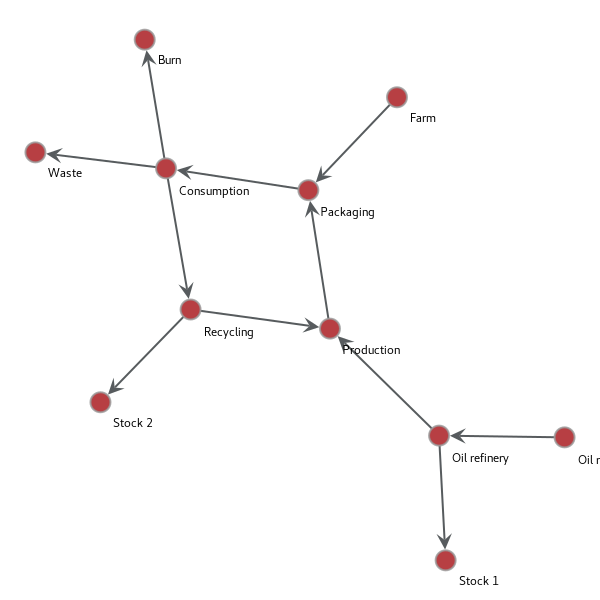

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f6392f4c048, at 0x7f6392f5d160>

In [4]:
gt.draw.graph_draw(G, vertex_size=20, vertex_text=G.vp.id,
                   vprops={"text_position":1})

In [91]:
def split_flows(G):
    """Split the flows based on material composition
    
    If a flow is composed of different materials, it is split into individual flows per material 
    with the corresponding mass.
    If the flow is composed of a single material, the composition property is removed and replaced with material.
    
    Returns
    -------
    graph
        Edges with two properties: mass, material
    """
    g = G.copy()
    g.clear_edges()
    del g.edge_properties['flow']
    eprops = G.edge_properties.keys()
    mass_list = []
    material_list = []
    assert 'flow' in eprops, "The graph must have 'flow' edge property"
    e_list = []
    for e in G.edges():
        prop = G.ep.flow[e]
        assert isinstance(prop, dict), "Edge property flow must be a dictionary in edge {}".format(e)
        for material, percent in prop['composition'].items():
            e_list.append(np.array([e.source(), e.target()], dtype=int))
            mass_list.append(float(prop['mass']) * float(percent))
            material_list.append(material)
    e_array = np.vstack(e_list)
    g.add_edge_list(e_array)
    eprop_mass = g.new_edge_property("double", vals=mass_list)
    eprop_material = g.new_edge_property("string", vals=material_list)
    return (g, eprop_material, eprop_mass)

In [92]:
g_split, eprop_material, eprop_mass = split_flows(G)